# Reservoir Computers and Echo State Networks

In [6]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/ML-DS-Workshop-23/projects/ReservoirComputing`


## Contents
1. [Reservoir Computers and Echo State Networks](#esn)
2. [Recap: Hyperparameters and Cross-Validation](#cv)
3. [ReservoirComputing.jl](#rcjl)
4. [Further Reading](#further-reading)

## 1. Reservoir Computers and Echo State Networks <a class="anchor" id="esn"></a>

### 1.1. Overview

- Motivated by the difficulties associated with training recurrent neural networks (RNNs) via gradient-based methods, in 2001 a new class of RNN was proposed independently by [Maass et al. 2022](https://doi.org/10.1162/089976602760407955), under the name **Liquid State Machines** (LSMs), and [Jaeger 2001](https://www.ai.rug.nl/minds/uploads/EchoStatesTechRep.pdf), under the name **Echo State Networks** (ESNs). 
<br>

- Together, these approaches to RNN design are collectively referred to as **reservoir computing** (RC). We will focus on ESNs.
<br>

- A typical ESN looks like:

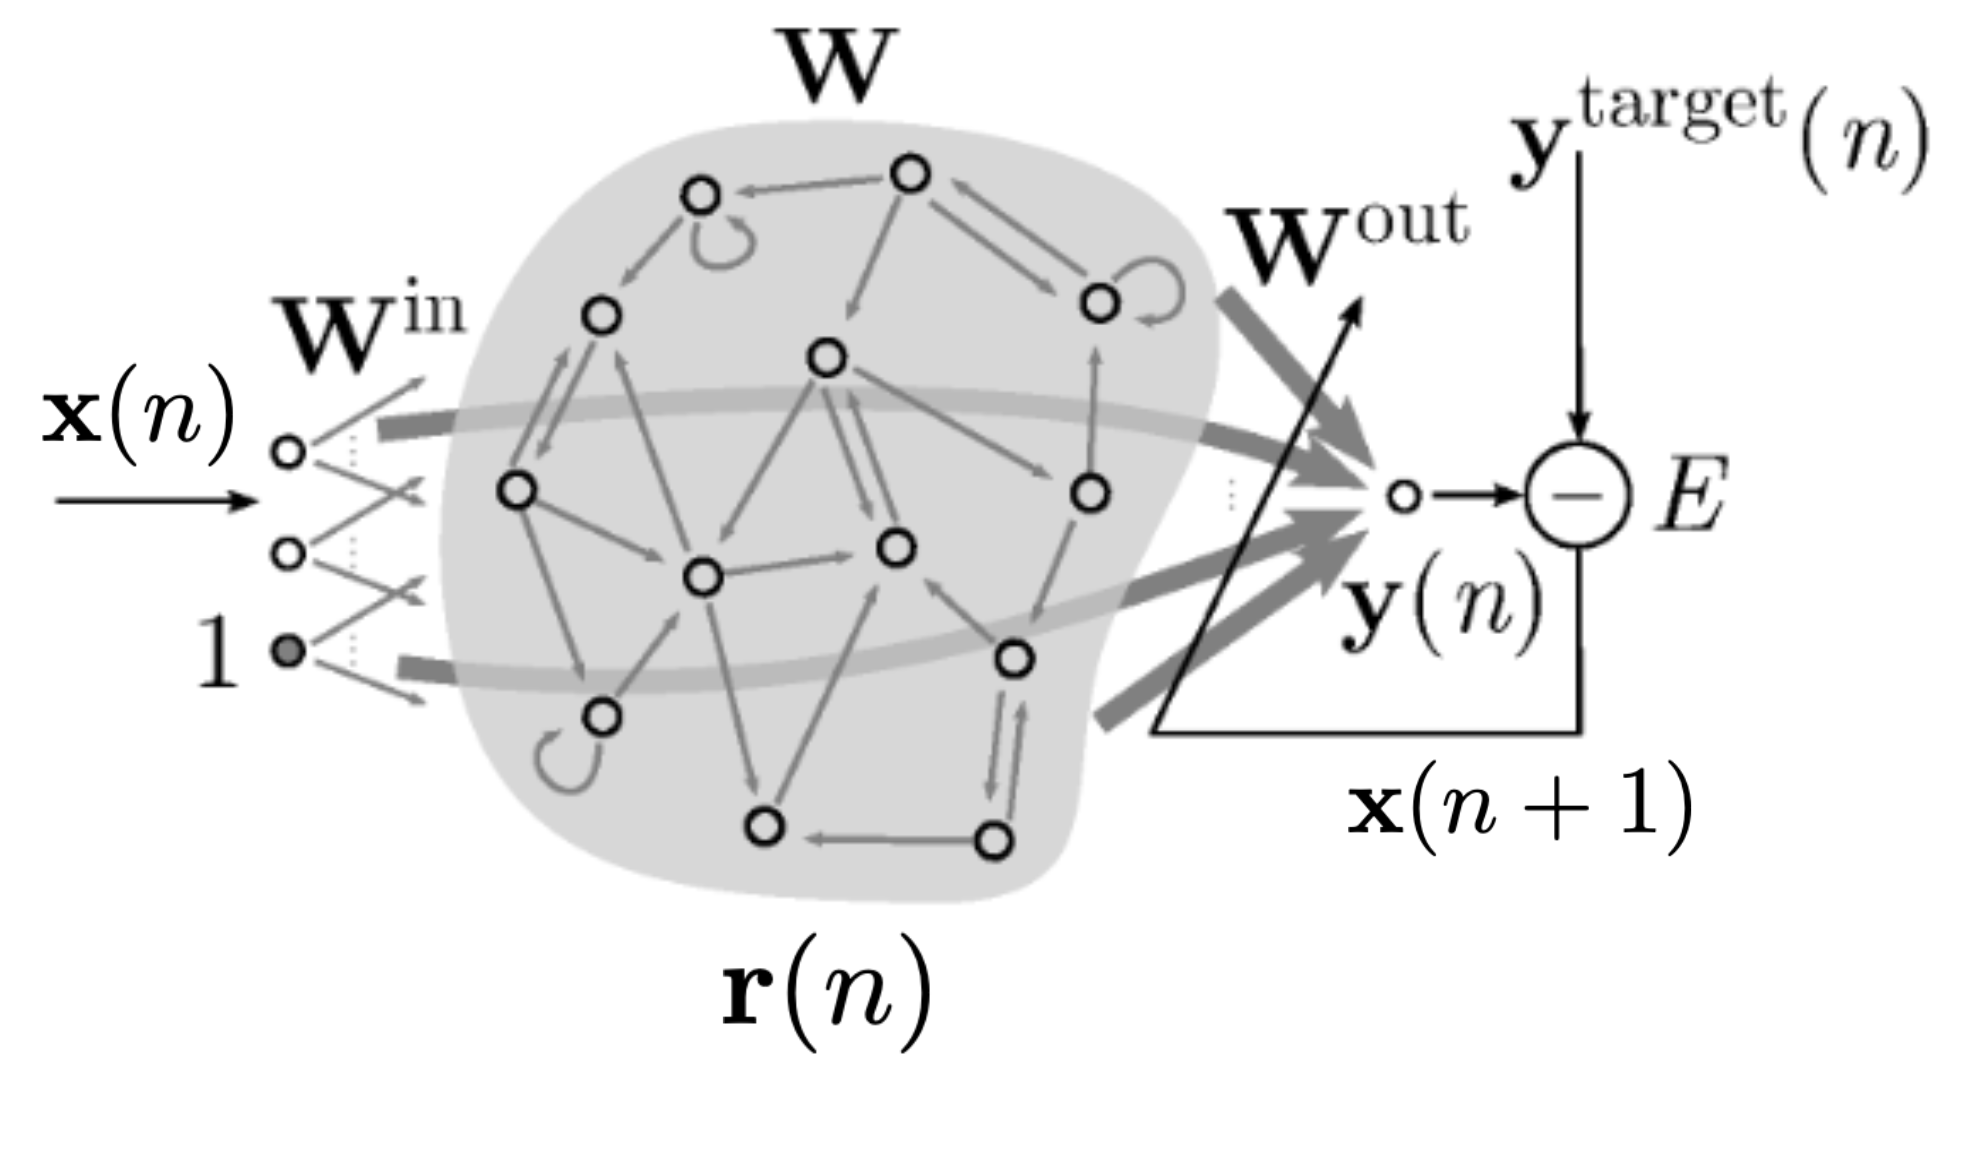
[Figure: Adapted from Lukoševičius (2012)](https://link.springer.com/chapter/10.1007/978-3-642-35289-8_36)

where 

1. $n$ is the discrete time index,
2. $\mathbf x(n) \in \mathbb{R}^{N_x}$ is the input signal,
3. $\mathbf r(n) \in \mathbb{R}^{N_r}$ are the reservoir activations,
4. $\mathbf W^{\mathrm{in}} \in \mathbb{R}^{N_r \times N_x}$ are the input-to-reservoir weights,
5. $\mathbf W \in \mathbb{R}^{N_r \times N_r}$ are the reservoir-to-reservoir weights, 
6. $\mathbf W^{\mathrm{out}} \in \mathbb{R}^{N_y \times N_r}$ are the reservoir-to-output weights, and 
7. $\mathbf y(n) \in \mathbb{R}^{N_y}$ is the network output.


- As the input sequence $\mathbf x(n)$ is fed into the ESN, the reservoir state $\mathbf r(n)$ and the output $\mathbf y(n)$ are updated according to the update equations

$$\begin{aligned}
\mathbf{\tilde r} (n) &= g\left (\mathbf W^{\mathrm{in}}\mathbf x (n) + \mathbf W \mathbf r (n-1)\right )\\
\mathbf r(n) &= (1-\alpha)\mathbf r(n-1) + \alpha \mathbf{\tilde r}(n)\\
\mathbf y(n) &= \mathbf{W}^{\mathrm{out}}\mathbf r(n),
\end{aligned}
$$

where $g$ is a sigmoidal activation function applied element-wise and $\alpha \in (0,1]$ is the _leaking rate_. We can think of the leaking rate $\alpha$ as controlling the "speed" of the update dynamics. In most studies on dynamical systems $\alpha = 1$.
<br>

- As we can see from the update equations, the reservoir activations at a given time $n$ are a function of the reservoir activations at the previous time $n-1$ _and_ the input signal at time $n$. An echo state network is therefore an example of a recurrent neural network.
<br>

- For simplicity, we will restrict our attention to the case where $\alpha = 1$, i.e. without leaky integration, and we will use a $\tanh$ activation function, which is a common default. The update equations for this simplified configuration are

$$\begin{aligned}
\mathbf{r} (n) &= \tanh\left (\mathbf W^{\mathrm{in}}\mathbf x (n) + \mathbf W \mathbf r (n-1)\right ), \\
\mathbf y(n) &= \mathbf{W}^{\mathrm{out}}\mathbf r(n),
\end{aligned}
$$

which is the form we will consider from now on.
<br>

- **The essential feature of a reservoir computer is that $\mathbf W$ and $\mathbf W^{\mathrm{in}}$, which define the reservoir dynamics, are generated randomly ahead of time and then fixed**. 
<br>

- That is, the weight matrices $\mathbf W$ and $\mathbf W^{\mathrm{in}}$ are not directly optimised during training.
<br>

- The output of the network $\mathbf y(n)$ is a linear combination of the reservoir activations $\mathbf r(n)$, meaning we can solve directly for the output weights $\mathbf W^{\mathrm{out}}$ using linear regression, minimising the MSE between the model prediction $\mathbf y(n) = \mathbf W^{\mathrm{out}} \mathbf r(n)$ and the training target $\mathbf y^{\mathrm{target}}(n)$.
<br>

- As a result of this procedure, **we avoid completely the need to take gradients through the network**, thus sidestepping the problems of vanishing and exploding gradients which can occur when training RNNs.

### 1.2. The Echo State Property

- It is important that an ESN possesses the *echo state property*, meaning that the effect of a previous state $\mathbf r(n)$ and a previous input $\mathbf x(n)$ on a future state $\mathbf r(n+k)$ should vanish as time passes ($k \to \infty$), i.e. the effect of the previous state should neither persist nor get amplified.
<br>

- For most practical purposes, the echo state property is assured if the reservoir weight matrix $\mathbf W$ is scaled so that its spectral radius $\rho (\mathbf W)$, i.e., the largest absolute eigenvalue of $\mathbf W$, satisfies $\rho (\mathbf W) < 1$.
<br>

- In certain cases, the echo state property may also be satisfied even with $\rho (\mathbf W) > 1$, while it may also not be satisifed even with $\rho (\mathbf W) < 1$.
<br>

- The optimal value of $\rho (\mathbf W)$ should be set depending on the amount of "memory" and nonlinearity required by the task at hand.
<br>

- As a rule of thumb, $\rho (\mathbf W)$ should be close to 1 for tasks requiring long-term memory, and smaller otherwise.

### 1.3. Training ESNs Is Easy: A Practical Guide to ESN Hyperparameters

- As we discussed earlier, the basic method for training an ESN consists of:

    1. Generate a large random reservoir, defined by $\mathbf W^{\mathrm{in}}$ and $\mathbf W$.  
    2. Run it using the training input $\mathbf x(n)$ and collect the corresponding reservoir activations $\mathbf r(n)$
    3. Compute the linear readout weights $\mathbf W^{\mathrm{out}}$ using linear regression, minimising the MSE between $\mathbf y(n) = \mathbf W^{\mathrm{out}}\mathbf r(n)$ and $\mathbf y^{\mathrm{target}}(n)$.<br><br>

- While the reservoir is fixed once it has been generated, a number of important hyperparameters control the process used to generate $\mathbf W^{\mathrm{in}}$ and $\mathbf W$.
<br>

- In essence, optimisation of ESNs consists of choosing optimal hyperparameters rather than optimising the network weights.

    
#### 1.3.1 Reservoir Size

- The reservoir acts as both a nonlinear expansion and a memory of the input $\mathbf x(n)$.
<br>

- The goal is that the reservoir should constitute a sufficiently rich and relevant signal space in $\mathbf r(n)$ that the desired $\mathbf y^{\mathrm{target}}(n)$ can be obtained as a linear combination from it.
<br>

- The bigger the space of reservoir signals $\mathbf r(n)$, the easier it is to find a linear combination of the signals to approximate $\mathbf y^{\mathrm{target}}(n)$.
<br>

- In general, the bigger the reservoir, the better the performance, *provided appropriate regularisation measures are taken against overfitting*.
<br>

#### 1.3.2. Reservoir Sparsity

- Sparse reservoir connections, i.e. setting most of the elements of $\mathbf W$ equal to zero, can have a small but positive effect on performance.
<br>

- More importantly, sparse matrix representations can have a significant effect on the cost of reservoir updates, significantly speeding up the model, assuming the underlying model implementation takes advantage of the sparsity.
<br>

- It is generally recommend to connect each reservoir node to a small fixed number of other nodes (e.g. 10) on average, regardless of the reservoir size.
<br>

#### 1.3.3. Spectral Radius of the Reservoir

- The nonzero elements of the reservoir connection matrix $\mathbf W$ are typically drawn from a symmetric uniform distribution.
<br>

- One of the most important hyperparameters of an ESN is the spectral radius $\rho (\mathbf W)$, i.e the maximum absolute eigenvalue of $\mathbf W$.
<br>

- Generally, a random sparse $\mathbf W$ is generated, its spectral radius $\rho (\mathbf W)$ is computed, then $\mathbf W$ is divided by $\rho (\mathbf W)$ to obtain a matrix with unit spectral radius.
<br>

- This $\mathbf W$ with unit spectral radius should be considered an initial starting point for training, with the final value of $\rho (\mathbf W)$ chosen to optimise performance.
<br>

- In general, $\rho (\mathbf W)$ should be greater for tasks where a more extensive history of the input is required to perform it, and smaller for tasks where the current output $\mathbf y(n)$ depends more on the recent history of $\mathbf x(n)$. 

#### 1.3.4. Input Scaling

- $\mathbf W_{\mathrm{in}}$ is typically dense rather than sparse, with its elements also drawn from a symmetric uniform distribution.
<br>

- We define the input scaling $a$ as the range of the interval $[-a, a]$ from which the values of $\mathbf W_{\mathrm{in}}$ are sampled.
<br>

- To keep the number of model hyperparameters to a minimum, often all the columns of $\mathbf W_{\mathrm{in}}$ are scaled with the same parameter $a$. However, if the individual components of $\mathbf x(n)$ contribute to the task in very different ways, each column of $\mathbf W_{\mathrm{in}}$ may be scaled differently.

### 1.4. ESNs for Prediction of Dynamical Systems

- We will consider the prediction paradigm where we are given a timeseries corresponding to some dynamical system and we wish to predict the future trajectory of that system.
<br>

- We will thus use an ESN in two configurations:
    1. In the **training phase**, the input to the ESN is set to the previous value of the timeseries, that is, $\mathbf x(n) = \mathbf y^{\mathrm{target}}(n-1)$. In essence, we are training the ESN to predict the next value of the timeseries, given the trajectory up to that point.
    2. In the **prediction phase**, we switch the input to the previous prediction of the ESN, that is, $\mathbf x(n) = \mathbf y(n-1)$. In this configuration, the ESN can be run autonomously to generate a timeseries of arbitrary duration.
<br>

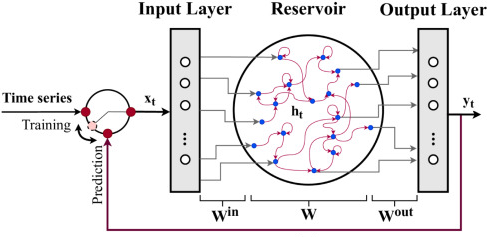
[Figure: Shahi et al. 2022](https://doi.org/10.1016/j.mlwa.2022.100300)

## 2. Recap: Hyperparameters and Cross-Validation <a class="anchor" id="cv"></a>
- Most machine learning algorithms have **hyperparameters**, which we can think of as settings controlling the algorithm's behaviour.
<br>

- Common hyperparameters in neural networks include the depth and width of the network, the choice of activation function, and the type and amount of regularisation.
<br>

- We call these settings hyperparameters to distinguish them from the model parameters which are directly adapted by the learning algorithm itself (say, neural network weights which are adapted by a gradient descent algorithm, or the output weights $\mathbf W^{\mathrm{out}}$ of an ESN).
<br>

- In general, **it is not appropriate to optimise a hyperparameter on the training set**. For example, consider hyperparameters which control model capacity; we can always obtain a better fit to the training data by simply increasing the model capacity, but this is likely to result in overfitting and consequently poor generalisation to unseen data.
<br>

- Remember that we use an independent **test set** to estimate the generalisation error of a trained machine learning model. As always, it is essential that the test set is not used to make any decisions about the model, including its hyperparameters.
<br>

- To choose the optimal hyperparameters, we use a further independent **validation set** to estimate the generalisation error of an optimised machine learning model, *for a given set of hyperparameters*. The final choice of model will generally be the one with the lowest error on the validation set.
<br>

- To summarise, a rough outline of the procedure is:
    1. Split the data into training, validation, and test sets.
    2. For a given set of hyperparameters, train the model on the training set. Once training has completed, evaluate the model error on the validation set.
    3. Repeat step 2 for all relevant hyperparameter combinations.
    4. Select the model which has the lowest error *on the validation set*.
    5. For this model, evaluate the model error on the test set. This is our estimate of the model's generalisation error.

In [ ]:
"""
    train_val_test_split(data; val_seconds, test_seconds, Δt)

Split the given data into training, validation, and test sets.
"""
function train_val_test_split(data; val_seconds, test_seconds, Δt)
    N_total = size(data, 2)
    N_val = round(Int, val_seconds / Δt)
    N_test = round(Int, test_seconds / Δt)
    
    split_index_1 = N_total - N_test - N_val
    split_index_2 = N_total - N_test
    
    train_data = data[:, 1:split_index_1]
    val_data = data[:, split_index_1+1:split_index_2]
    test_data = data[:, split_index_2+1:end]
    
    return train_data, val_data, test_data
end

## 3. ReservoirComputing.jl <a class="anchor" id="rcjl"></a>

### 3.1. A Step-By-Step Guide to Training an Echo State Network in Julia

- [ReservoirComputing.jl](https://github.com/SciML/ReservoirComputing.jl) provides an implementation of reservoir computers in Julia.
<br>

- As a worked example, we will train an Echo State Network to reproduce the dynamics of the Lorenz system.

In [54]:
using DynamicalSystems    # Useful Julia package containing many pre-defined dynamical systems and tools for their analysis
using ReservoirComputing  # Julia implementation of reservoir computers
using Printf              # Nice C-style string formatting
using Plots

#### Step 0: Generate the Synthetic Training Data

- First we set up the Lorenz system. For this example we'll use the pre-defined system from [DynamicalSystems.jl](https://juliadynamics.github.io/DynamicalSystems.jl/latest/).
<br>

- For many more pre-defined dynamical systems see the [documentation](https://juliadynamics.github.io/DynamicalSystems.jl/latest/ds/predefined/).

In [59]:
system = Systems.lorenz63()  # Use default params and initial conditions

3-dimensional continuous dynamical system
 state:       [0.0, 10.0, 0.0]
 rule f:      loop
 in-place?    false
 jacobian:    loop_jac
 parameters:  [10.0, 28.0, 2.66667]

- Next we compute the maximum Lyapunov exponent of the system. We'll use this later to scale and benchmark the prediction timescales of our ESN model.
<br>

- For this we can simply use the `lyapunov` method from DynamicalSystems.jl (as always, remember that you can inspect docstrings by doing `?lyapunov`).

In [65]:
λ_max = lyapunov(
    system,     # Dynamical system (can be either user-defined or pre-defined)
    1e4,        # Total integration time for computing λ_max
    Ttr = 100,  # Transient integration time (will be discarded)
)

0.9056697568289074

- Looks about right.
<br>

- Finally, we integrate a single trajectory of the system for use as our training data. For this we use the `trajectory` method from DynamicalSystems.jl.

In [62]:
# Integration parameters
Ttr = 100.0  # Transient integration time
T = 200.0    # Total time (excluding transient)
Δt = 0.1     # Timestep

# Integrate a trajectory
tr = trajectory(system, T; Δt, Ttr)

# Put the data in the matrix format (n_features, n_samples) required by ReservoirComputing.jl 
data = copy(transpose(Matrix(tr)))

3×2001 Matrix{Float64}:
 15.7333   6.88912   0.472741  -1.87952  …   4.38595   9.11992  14.9238
 11.4268  -2.48685  -3.23666   -3.49162      7.58944  15.3972   17.7684
 40.6889  34.6858   25.7252    19.97        12.8767   16.7364   32.7353

 - Under the hood, DynamicalSystems.jl uses the solvers from [OrdinaryDiffEq.jl](https://docs.sciml.ai/OrdinaryDiffEq/stable/). You can directly specify the choice of solver algorithm and parameters using the `diffeq` keyword arg of `trajectory`. See the [docs](https://juliadynamics.github.io/DynamicalSystems.jl/latest/ds/general/#DynamicalSystemsBase.trajectory) for examples.

#### Step 1: Generate the Input Layer

- For $\mathbf W_{\mathrm{in}}$ we will use `WeightedLayer`, which means that each reservoir node is connected to exactly one component of the input signal $\mathbf x$, as described in [Lu et al. 2017](https://aip.scitation.org/doi/10.1063/1.4979665). In other words, each component of $\mathbf x$ is connected to $N_r / N_x$ reservoir nodes.
<br>

- The weights are drawn from a uniform distribution on $[-a,a]$ (which makes $a$ our first hyperparameter).

In [108]:
a = 0.1
Wᵢₙ = WeightedLayer(scaling = a)

WeightedLayer{Float64}(0.1)

- [Several other choices](https://docs.sciml.ai/ReservoirComputing/stable/api/esn_layers/#Input-Layers) are possible for the input layer, for example `DenseLayer`, which presumably means that every reservoir node is connected to every component of the input signal $\mathbf x$, but the docs are not clear on this.

#### Step 2: Generate the Reservoir

- Next we generate a random sparse reservoir, based on three hyperparameters:

1. The reservoir size $N_r$, i.e. the number of nodes,
2. The spectral radius $\rho(\mathbf W)$,
3. The reservoir sparsity, i.e. how many other nodes each node is connected to, on average.

In [72]:
reservoir_size = 1000           # Number of nodes in the reservoir
spectral_radius = 1.0           # Good starting value
sparsity = 10 / reservoir_size  # Each node is connected to 10 others, on average

W = RandSparseReservoir(reservoir_size, radius = spectral_radius, sparsity = sparsity)

RandSparseReservoir{Float64, Float64}(1000, 1.0, 0.01)

- Remember that the reservoir weights are actually represented by an $N_r \times N_r$ adjacency matrix.

#### Step 3: Create the ESN
- Now that we have created the input layer and the reservoir, we can create our echo state network.
<br>

- In ReservoirComputing.jl, for some reason the input signal $\mathbf x$ is part of the ESN object and must therefore be provided to the constructor. Since we are interesting in one-step ahead time series prediction, the input signal will consist of the entire training data except for the last observation.

In [77]:
x = data[:, 1:end-1]

3×2000 Matrix{Float64}:
 15.7333   6.88912   0.472741  -1.87952  …   2.26578   4.38595   9.11992
 11.4268  -2.48685  -3.23666   -3.49162      3.51788   7.58944  15.3972
 40.6889  34.6858   25.7252    19.97        14.751    12.8767   16.7364

- Creating the ESN is then as simple as calling the `ESN` constructor:

In [70]:
esn = ESN(x; reservoir = W, input_layer = Wᵢₙ)

ESN{Int64, Matrix{Float64}, Default, NLADefault, Matrix{Float64}, RNN{typeof(NNlib.tanh_fast), Float64}, Matrix{Float64}, Matrix{Float64}, StandardStates, Int64, Matrix{Float64}}(1000, [15.733250759698066 6.889122741047136 … 4.385950900993857 9.1199178636946; 11.426787334960105 -2.4868502087982605 … 7.589438356650147 15.397215703626221; 40.68889130354992 34.68575244185789 … 12.876688828773874 16.736363469601855], Default(), NLADefault(), [0.030565022406621845 -0.06136662315753181 0.04707046183335578; -0.031228056960411157 -0.015587689116031894 -0.09388712480351435; … ; -0.02748378208335392 0.028488322819721218 -0.04794311243460823; -0.07115112148898335 0.05603502814633038 -0.030903993386902792], RNN{typeof(NNlib.tanh_fast), Float64}(NNlib.tanh_fast, 1.0), [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0; 0.0; … ; 0.0; 0.0;;], StandardStates(), 0, [0.9347695696504885 0.9628633799811028 … -0.016461902696888877 0.04379705334727605; -0.9997480240637663

- For convenience, here we will define a method that combines steps 1-3, i.e. it creates the input layer, reservoir, and ESN all together (this will be handy later when doing hyperparameter optimisation).

In [36]:
"""
    generate_esn(input_signal, reservoir_size = 1000, spectral_radius = 1.0, sparsity = 0.1, input_scale = 0.1)

Generate an Echo State Network consisting of the reservoir weights W and the input weights Wᵢₙ.
"""
function generate_esn(
    input_signal,
    reservoir_size = 1000,
    spectral_radius = 1.0,
    sparsity = 0.1,
    input_scale = 0.1,
)
    Wᵢₙ = WeightedLayer(scaling = input_scale)
    W = RandSparseReservoir(reservoir_size, radius = spectral_radius, sparsity = sparsity)
    return ESN(input_signal, reservoir = W, input_layer = Wᵢₙ)
end

generate_esn

#### Step 4: Train the ESN

- With the ESN in hand, now we just need to train it.
<br>

- Remember, all we have to do is find the optimal values of $\mathbf W_{\mathrm{out}}$ using a suitable convex optimisation method, e.g. ordinary least squares.
<br>

- We will use [ridge regression](https://en.wikipedia.org/wiki/Ridge_regression), which applies a regularisation penalty $\lambda$ to the $l_2$ norm of the regression coefficients. Setting $\lambda = 0$ returns the ordinary least squares solution.

In [73]:
ridge_param = 0.0  # OLS
training_method = StandardRidge(ridge_param)

StandardRidge{Float64}(0.0)

- We also need the training data, in our case the one-step ahead value of the time series (meaning `y_target` is simply from `x` by one timestep).

In [75]:
y_target = data[:, 2:end]

3×2000 Matrix{Float64}:
  6.88912   0.472741  -1.87952  -3.62106  …   4.38595   9.11992  14.9238
 -2.48685  -3.23666   -3.49162  -5.80209      7.58944  15.3972   17.7684
 34.6858   25.7252    19.97     16.4055      12.8767   16.7364   32.7353

- Finally, compute $\mathbf W_{\mathrm{out}}$ by calling the `train` method on the ESN along with the target data and the training method.

In [76]:
Wₒᵤₜ = train(esn, y_target, training_method)

OutputLayer{StandardRidge{Float64}, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}, Int64, Vector{Float64}}(StandardRidge{Float64}(0.0), [-0.07763754366660214 -7.682489073565917 … -0.02107402171780343 -0.07737106743843791; -0.3572635069031279 -48.11034280044092 … -0.20024034253778059 -0.31586238648598036; -0.874109551532066 -3.9032560203981586 … -1.3511939525889016 0.06641465783837498], 3, [14.923837368101296, 17.768431643994443, 32.73530687917551])

- Once again, we define a convenience method to automate this process slightly:

In [38]:
"""
    train_esn!(esn, y, ridge_param)

Given an Echo State Network, train it on the target sequence y_target and return the optimised output weights Wₒᵤₜ.
"""
function train_esn!(esn, y_target, ridge_param)
    training_method = StandardRidge(ridge_param)
    return train(esn, y_target, training_method)
end

train_esn!

#### Step 5: Predict

- In ReservoirComputing.jl, an ESN can be run in one of two (badly named) [settings](https://docs.sciml.ai/ReservoirComputing/stable/general/predictive_generative/):

1. __Predictive__: The input signal to the reservoir is provided by the user. This is the method used when _training_ the ESN.
2. __Generative__: The input signal to the reservoir at the current timestep is equal to the output of the ESN at the previous timestep. In this setting, the ESN can be run autonomously, making predictions of arbitrary duration into future.

- To make a prediction of length $N$ steps in "generative" mode, call the ESN with `Generative(N)` and the output weights, i.e.

In [81]:
steps_to_predict = 100
prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)

3×100 Matrix{Float64}:
 11.4054    3.75798   0.39486  -0.703365  …   0.24614   0.597425  1.5422
  3.06276  -1.76251  -1.35915  -1.47157       0.461142  1.14381   3.05048
 38.2285   29.2634   22.1665   17.0087       10.2004    7.84103   6.19524

- The initial conditions of the prediction are defined by the state (i.e. activations) of the reservoir at the end of the training data.
<br>

- And yes, the API is terribly designed.
<br>

- TODO: Compare against a test set and add a plot here.

### 3.2. Hyperparameter Optimisation

- Earlier we said that "training" an ESN essentially boils down to selecting optimal hyperparameters.
<br>

- We will now demonstrate a staightforward cross-validation procedure for doing exactly this.
<br>

- First we define a simple struct to hold the ESN hyperparameters.

In [103]:
"""
Hyperparameters for an Echo State Network.
"""
struct ESNHyperparameters
    reservoir_size
    spectral_radius
    sparsity
    input_scale
    ridge_param
end

ESNHyperparameters

- Then we set up a "grid search" over possible values of the hyperparameters.

In [105]:
param_grid = ESNHyperparameters[]  # List of objects of type ESNHyperparameters

reservoir_sizes = [512, 1024]
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1]
ridge_values = [0.0]  # No noise so OLS is fine

# Take the Cartesian product of the possible hyperparameter values
for params in Iterators.product(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
    push!(param_grid, ESNHyperparameters(params...))
end

println("$(length(param_grid)) hyperparameter combinations.")

12 hyperparameter combinations.


- Split the data up into training, validation, and test sets.

In [109]:
train_data, val_data, test_data = train_val_test_split(data; val_seconds = 10.0, test_seconds = 10.0, Δt)

([15.733250759698066 6.889122741047136 … 5.191130878215592 -0.3014950460491832; 11.426787334960105 -2.4868502087982605 … -3.2924653352798723 -3.383123877260647; 40.68889130354992 34.68575244185789 … 32.80214861358305 24.547591549858577], [-2.3877120643591807 -4.373041944068131 … -4.7261110667017965 -8.068807682113716; -4.033819966306699 -6.984695093120641 … -6.982618465218277 -12.471592524579119; 19.281678187908575 16.3806065635955 … 17.391870985331906 18.801923049333062], [-12.56043264796824 -12.164868433604946 … 9.1199178636946 14.923837368101296; -15.931574366181804 -7.832541324588022 … 15.397215703626221 17.768431643994443; 28.300471545151144 35.95764714169392 … 16.736363469601855 32.73530687917551])

- Next we train the ESN _for each combination of hyperparameters_, evaluating each model on the validation set and keeping the model with the lowest validation error.

In [90]:
"""
    cross_validate_esn(train_data, val_data, param_grid)

Do a grid search on the given param_grid to find the optimal hyperparameters.
"""
function cross_validate_esn(train_data, val_data, param_grid)
    best_loss = Inf
    best_params = nothing

    # We want to predict one step ahead, so the input signal is equal to the target signal from the previous step
    x_train = train_data[:, 1:end-1]
    y_train = train_data[:, 2:end]
        
    for hyperparams in param_grid        
        # Unpack the hyperparameter struct
        (;reservoir_size, spectral_radius, sparsity, input_scale, ridge_param) = hyperparams

        # Generate and train an ESN
        esn = generate_esn(x_train, reservoir_size, spectral_radius, sparsity, input_scale)
        Wₒᵤₜ = train_esn!(esn, y_train, ridge_param)

        # Evaluate the loss on the validation set
        steps_to_predict = size(val_data, 2)
        prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
        loss = sum(abs2, prediction .- val_data)
        
        # Keep track of the best hyperparameter values
        if loss < best_loss
            best_loss = loss
            best_params = hyperparams
        end
    end
    
    println("Optimal hyperparameters: $(best_params)")
    println("Validation loss = ", @sprintf "%.1e" best_loss)
    
    # Retrain the model using the optimal hyperparameters on both the training and validation data
    # This is necessary because we don't want errors accumulated during validation to affect the test error
    (; reservoir_size, spectral_radius, sparsity, input_scale, ridge_param) = best_params
    data = hcat(train_data, val_data)
    x = data[:, 1:end-1]
    y = data[:, 2:end]
    esn = generate_esn(x, reservoir_size, spectral_radius, sparsity, input_scale)
    Wₒᵤₜ = train_esn!(esn, y, ridge_param)
    
    return esn, Wₒᵤₜ
end

cross_validate_esn

In [99]:
@time esn, Wₒᵤₜ = cross_validate_esn(train_data, val_data, param_grid);

Optimal hyperparameters: ESNHyperparams(1024, 1.0, 0.03, 0.1, 0.0)
Validation loss: 3.5e+02
 10.722186 seconds (101.50 k allocations: 619.415 MiB, 0.67% gc time)


- Finally, compare the model to the test set, plotting the prediction.

In [93]:
"""
    plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)

Given an Echo State Network, plot its predictions versus the given test set.
"""
function plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)
    steps_to_predict = size(test_data, 2)
    prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
    
    label = ["actual" "predicted"]
    times = Δt * collect(0:steps_to_predict)[1:end-1] * λ_max

    p1 = plot(times, [test_data[1, :], prediction[1, :]], label = label, ylabel = "x(t)")
    p2 = plot(times, [test_data[2, :], prediction[2, :]], label = label, ylabel = "y(t)")
    p3 = plot(times, [test_data[3, :], prediction[3, :]], label = label, ylabel = "z(t)", xlabel = "t * λ_max")
    plot(p1, p2, p3, layout = (3, 1), size = (800, 600))
end

plot_prediction

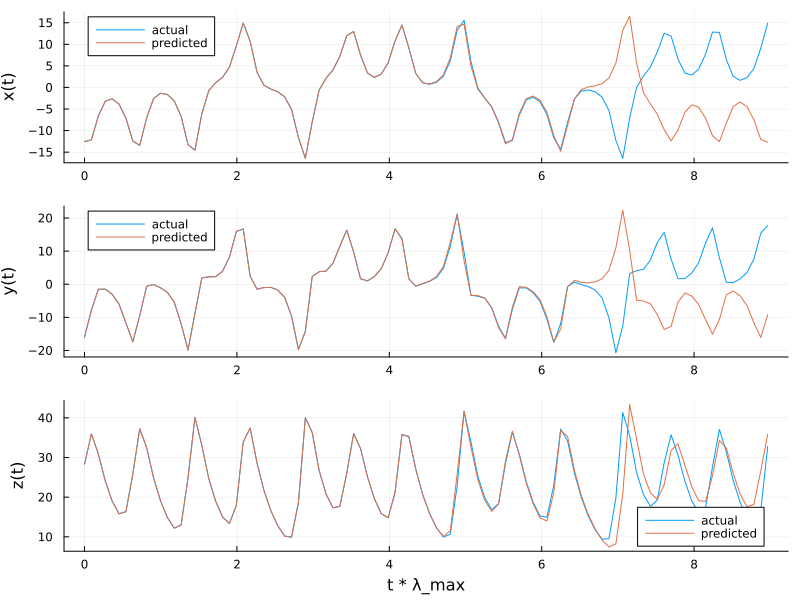

In [101]:
plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)

- Based on a very naive grid search, we get predictions that are valid up to 6 or 7 Lyapunov times. Not bad!

## 4. Further Reading <a class="anchor" id="further-reading"></a>
1. Recurrent Neural Networks
    1. [Deep Learning (Goodfellow et al. 2016)](https://www.deeplearningbook.org/)
    2. [Probabilistic Machine Learning: An Introduction (Murphy 2022)](https://probml.github.io/pml-book/book1.html)
2. Reservoir Computers
    1. [Reservoir computing approaches to recurrent neural network training (Lukoševičius & Jaeger 2009)](https://doi.org/10.1016/j.cosrev.2009.03.005)
    2. [A Practical Guide to Applying Echo State Networks (Lukoševičius 2012)](https://doi.org/10.1007/978-3-642-35289-8_36)
    3. [Efficient Cross-Validation of Echo State Networks (Lukoševičius & Uselis 2019)](https://doi.org/10.1007/978-3-030-30493-5_12)
3. Reservoir Computers for Prediction of Dynamical Systems
    1. [Using machine learning to replicate chaotic attractors and calculate Lyapunov exponents from data (Pathak et al. 2017)](https://aip.scitation.org/doi/10.1063/1.5010300)
    2. [Model-Free Prediction of Large Spatiotemporally Chaotic Systems from Data: A Reservoir Computing Approach (Pathak et al. 2018)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.120.024102)
    3. [Hybrid forecasting of chaotic processes: Using machine learning in conjunction with a knowledge-based model (Pathak et al. 2018)](https://aip.scitation.org/doi/10.1063/1.5028373)
    4. [Combining machine learning with knowledge-based modeling for scalable forecasting and subgrid-scale closure of large, complex, spatiotemporal systems (Wikner et al. 2020)](https://aip.scitation.org/doi/10.1063/5.0005541)
4. Reservoir Computers Applied to Climate Phenomena
    1. [Seasonal prediction of Indian summer monsoon onset with echo state networks (Mitsui & Boers 2021)](https://iopscience.iop.org/article/10.1088/1748-9326/ac0acb)